Loading training data...
Loaded 5216 training samples
Loading test data...
Loaded 624 test samples
Loading validation data...
Loaded 16 validation samples

Visualizing class distribution...


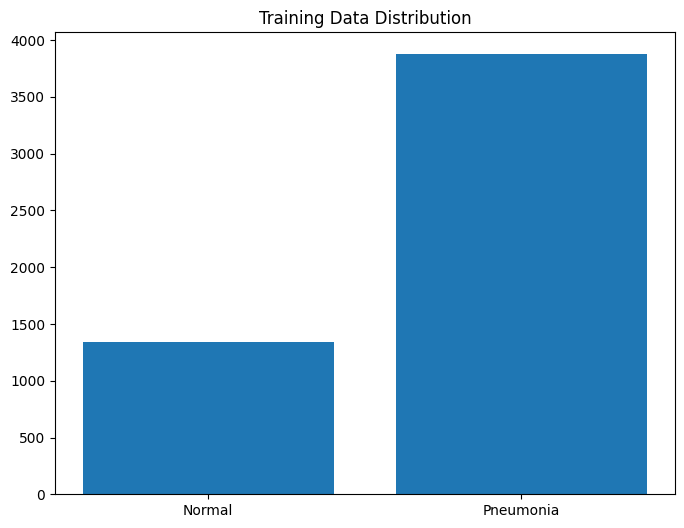


Data shapes:
X_train: (5216, 256, 256, 1), y_train: (5216,)
X_val: (16, 256, 256, 1), y_val: (16,)
X_test: (624, 256, 256, 1), y_test: (624,)

Building CNN model...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 256, 256, 32)      320       
                                                                 
 activation_4 (Activation)   (None, 256, 256, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 128, 128, 32)      0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 128, 128, 32)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 64)      18496     
                    

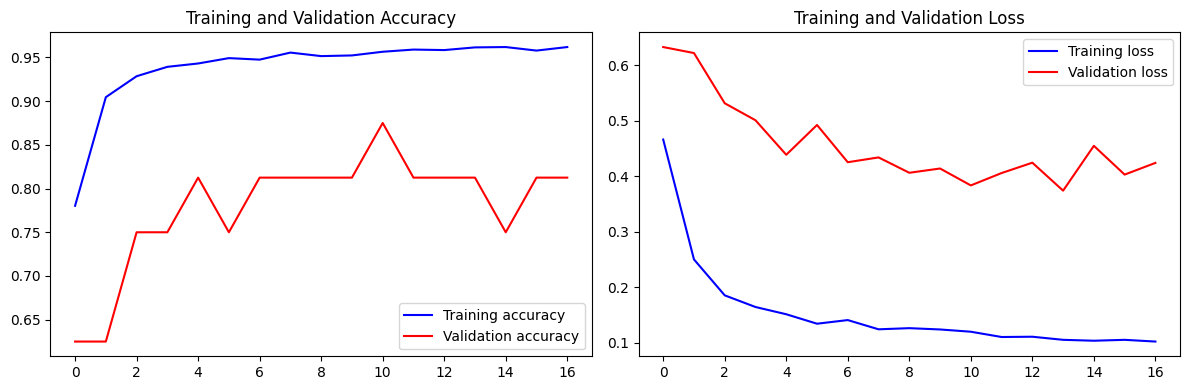


Making predictions on test data...
20/20 [==============================] - 3s 131ms/step
Correct predictions: 525
Incorrect predictions: 99


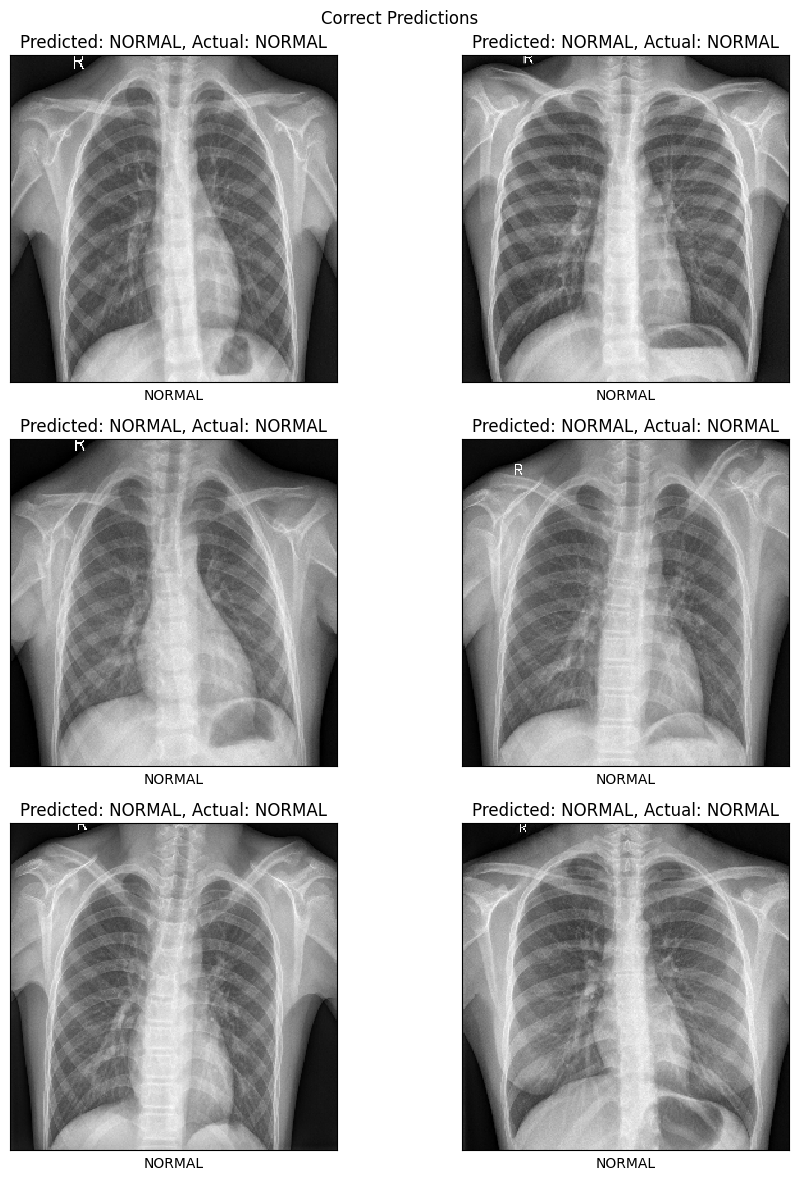

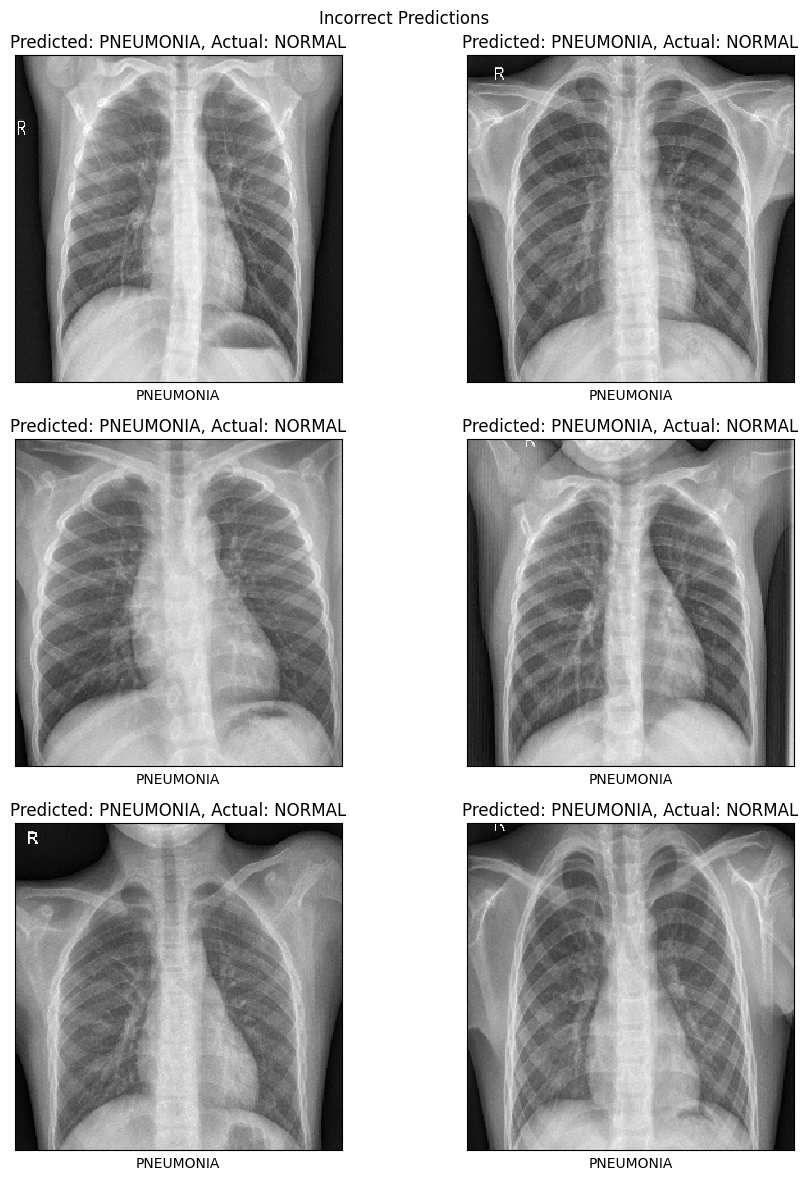


=== Prediction on External Images ===
To predict on a new image, use:
prediction = model.predict([prepare('path/to/image.jpg')])
result = labels[int(prediction[0] > 0.5)]
print(f'Prediction: {result}')


'\n# Load saved model from pickle\nimport pickle\nfrom tensorflow.keras.models import model_from_json\n\nwith open("cnn_model.pkl", "rb") as f:\n    payload = pickle.load(f)\n\nmodel = model_from_json(payload["model_json"])\nmodel.set_weights(payload["weights"])\n\n# Predict on external images\nprediction = model.predict([prepare("path/to/pneumonia_image.jpg")])\nprint(f"Prediction: {labels[int(prediction[0] > 0.5)]}")\n\nprediction = model.predict([prepare("path/to/normal_image.jpg")])\nprint(f"Prediction: {labels[int(prediction[0] > 0.5)]}")\n'

In [19]:
"""
Pneumonia Detection from Chest X-Ray Images using CNN
This program trains a convolutional neural network to classify chest X-rays 
as either NORMAL or PNEUMONIA.
"""

# Install required package (run in terminal):
# pip install opencv-python

import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
try:
    import seaborn as sns
    HAS_SEABORN = True
except ModuleNotFoundError:
    HAS_SEABORN = False
    print("Warning: seaborn is not installed; using matplotlib only for plots.")
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Conv2D, Activation, Dense, Dropout, MaxPooling2D
from tensorflow.keras.models import Sequential, model_from_json
import pickle

# Configuration
IMG_SIZE = 256
labels = ["NORMAL", "PNEUMONIA"]

# Directory paths
train_folder = "chest_xray/train"
test_folder = "chest_xray/test"
val_folder = "chest_xray/val"

def get_data(data_dir):
    """
    Load and preprocess image data from directory
    
    Args:
        data_dir: Path to data directory containing NORMAL and PNEUMONIA folders
    
    Returns:
        numpy array containing [image_array, class_label] pairs
    """
    data = []
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif')
    for label in labels:
        path = os.path.join(data_dir, label)
        if not os.path.exists(path):
            print(f"Warning: Directory {path} does not exist. Skipping...")
            continue
        class_num = labels.index(label)
        for img in os.listdir(path):
            if img.lower().endswith(image_extensions):
                try:
                    img_path = os.path.join(path, img)
                    img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img_array is not None:
                        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                        data.append([new_array, class_num])
                    else:
                        print(f"Warning: Could not read image {img}")
                except Exception as e:
                    print(f"Error loading {img}: {e}")
    return np.array(data, dtype=object)

# Load datasets
print("Loading training data...")
train = get_data(train_folder)
print(f"Loaded {len(train)} training samples")
print("Loading test data...")
test = get_data(test_folder)
print(f"Loaded {len(test)} test samples")
print("Loading validation data...")
val = get_data(val_folder)
print(f"Loaded {len(val)} validation samples")

# Check if datasets are empty
if len(train) == 0:
    print("\n⚠️  WARNING: Training dataset is empty!")
    print("   Please ensure 'chest_xray/train/NORMAL' and 'chest_xray/train/PNEUMONIA' folders exist.")
    print("   If you already have 'cnn_model.pkl', you can skip training and use it directly.")
    print("   To train: Download the dataset and place it in the 'chest_xray' folder.\n")
    # Don't raise error - allow user to load existing model instead
    TRAIN_AVAILABLE = False
else:
    TRAIN_AVAILABLE = True

if len(test) == 0:
    print("⚠️  WARNING: Test dataset is empty!")
    print("   Please ensure 'chest_xray/test/NORMAL' and 'chest_xray/test/PNEUMONIA' folders exist.\n")
    
if len(val) == 0:
    print("⚠️  WARNING: Validation dataset is empty.")
    print("   Consider using a portion of training data for validation.\n")

# Skip training if no data available
if not TRAIN_AVAILABLE:
    print("=" * 60)
    print("SKIPPING TRAINING: No dataset found.")
    print("If you have 'cnn_model.pkl', you can load it directly.")
    print("=" * 60)

# Visualize class distribution (only if data available)
if TRAIN_AVAILABLE and len(train) > 0:
    print("\nVisualizing class distribution...")
    l = ["Normal" if i[1] == 0 else "Pneumonia" for i in train]
    plt.figure(figsize=(8, 6))
    if HAS_SEABORN:
        sns.countplot(x=l)
    else:
        from collections import Counter
        counts = Counter(l)
        plt.bar(list(counts.keys()), list(counts.values()))
    plt.title("Training Data Distribution")
    plt.show()

# Prepare training data (only if available)
if TRAIN_AVAILABLE:
    X_train = []
    y_train = []
    for feature, label in train:
        X_train.append(feature)
        y_train.append(label)

    # Prepare test data
    X_test = []
    y_test = []
    for feature, label in test:
        X_test.append(feature)
        y_test.append(label)

    # Prepare validation data
    X_val = []
    y_val = []
    for feature, label in val:
        X_val.append(feature)
        y_val.append(label)

    # Normalize pixel values to [0, 1]
    X_train = np.array(X_train) / 255.0
    X_val = np.array(X_val) / 255.0
    X_test = np.array(X_test) / 255.0

    # Reshape for CNN input (samples, height, width, channels)
    X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    y_train = np.array(y_train)

    X_val = X_val.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    y_val = np.array(y_val)

    X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    y_test = np.array(y_test)

    print(f"\nData shapes:")
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
    print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
else:
    print("\n⚠️  Cannot prepare data - no training dataset found.")
    print("   Skipping model training. If you have 'cnn_model.pkl', load it directly.")

# Build CNN Model (only if training data available)
if not TRAIN_AVAILABLE:
    print("\n⚠️  Cannot build model - no training data available.")
    print("   If you have 'cnn_model.pkl', you can load it using the code at the bottom of this notebook.")
    model = None
else:
    print("\nBuilding CNN model...")
    model = Sequential([
    # Input layer
    Input(shape=X_train.shape[1:]),
    
    # First convolutional block
    Conv2D(32, (3, 3), padding="same"),
    Activation("relu"),
    MaxPooling2D(2, 2),
    Dropout(0.2),
    
    # Second convolutional block
    Conv2D(64, (3, 3), padding="same"),
    Activation("relu"),
    MaxPooling2D(2, 2),
    Dropout(0.5),
    
    # Third convolutional block
    Conv2D(128, (3, 3), padding="same"),
    Activation("relu"),
    MaxPooling2D(2, 2),
    Dropout(0.2),
    
    # Fourth convolutional block
    Conv2D(256, (3, 3), padding="same"),
    Activation("relu"),
    MaxPooling2D(2, 2),
    Dropout(0.2),
    
    # Fully connected layers
    Flatten(),
    Dense(256, activation="relu"),
    Dense(1, activation="sigmoid")
    ])

    # Compile model
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

    model.summary()

    # Train model
    print("\nTraining model...")
    if len(val) > 0:
        history = model.fit(
            X_train, y_train, 
            epochs=50, 
            validation_data=(X_val, y_val), 
            shuffle=True, 
            callbacks=[callback]
        )
    else:
        print("WARNING: No validation data. Training without validation split.")
        history = model.fit(
            X_train, y_train, 
            epochs=50, 
            shuffle=True, 
            callbacks=[callback]
        )

    # Evaluate model (only if we have test data)
    if len(test) > 0:
        print("\nEvaluating model on test data...")
        scores = model.evaluate(X_test, y_test)
        print(f"Test loss: {scores[0]:.4f}")
        print(f"Test accuracy: {scores[1]:.4f}")
    else:
        print("\nSkipping evaluation (no test data available)")

    # Save model as pickle payload (JSON + weights + metadata)
    model_payload = {
        "model_json": model.to_json(),
        "weights": model.get_weights(),
        "img_size": IMG_SIZE,
        "labels": labels,
    }
    with open("cnn_model.pkl", "wb") as f:
        pickle.dump(model_payload, f)
    print("\n✅ Model saved as 'cnn_model.pkl' (json + weights)")

    # Visualize training history
    print("\nGenerating training visualizations...")
    accuracy = history.history['accuracy']
    loss = history.history['loss']
    epochs = range(len(accuracy))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy, "b", label="Training accuracy")
    if 'val_accuracy' in history.history:
        val_accuracy = history.history['val_accuracy']
        plt.plot(epochs, val_accuracy, "r", label="Validation accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, "b", label="Training loss")
    if 'val_loss' in history.history:
        val_loss = history.history['val_loss']
        plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title("Training and Validation Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Make predictions (only if we have test data)
    if len(test) > 0:
        print("\nMaking predictions on test data...")
        predictions = (model.predict(X_test) > 0.5).astype(int).reshape(-1)

        # Find correct and incorrect predictions
        correct = np.nonzero(predictions == y_test)[0]
        incorrect = np.nonzero(predictions != y_test)[0]

        print(f"Correct predictions: {len(correct)}")
        print(f"Incorrect predictions: {len(incorrect)}")

        # Visualize correct predictions
        if len(correct) > 0:
            plt.figure(figsize=(10, 12))
            for j, i in enumerate(correct[:6]):
                plt.subplot(3, 2, j+1)
                plt.xticks([])
                plt.yticks([])
                plt.imshow(X_test[i].reshape(256, 256), cmap="gray", interpolation='none')
                plt.title(f"Predicted: {labels[predictions[i]]}, Actual: {labels[y_test[i]]}")
                plt.xlabel(labels[predictions[i]])
            plt.suptitle("Correct Predictions")
            plt.tight_layout()
            plt.show()

        # Visualize incorrect predictions
        if len(incorrect) > 0:
            plt.figure(figsize=(10, 12))
            for j, i in enumerate(incorrect[:6]):
                plt.subplot(3, 2, j+1)
                plt.xticks([])
                plt.yticks([])
                plt.imshow(X_test[i].reshape(256, 256), cmap="gray", interpolation='none')
                plt.title(f"Predicted: {labels[predictions[i]]}, Actual: {labels[y_test[i]]}")
                plt.xlabel(labels[predictions[i]])
            plt.suptitle("Incorrect Predictions")
            plt.tight_layout()
            plt.show()
    else:
        print("\nSkipping predictions visualization (no test data available)")

# Function to prepare external images for prediction (works regardless of training)
def prepare(filepath):
    """
    Prepare an external image for prediction
    
    Args:
        filepath: Path to image file
    
    Returns:
        Preprocessed image array ready for model prediction
    """
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    normalized = new_array / 255.0
    return normalized.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

# Example: Load model and predict on new images
print("\n=== Prediction on External Images ===")
print("To predict on a new image, use:")
print("prediction = model.predict([prepare('path/to/image.jpg')])")
print("result = labels[int(prediction[0] > 0.5)]")
print("print(f'Prediction: {result}')")

# Uncomment below to test on external images:
"""
# Load saved model from pickle
import pickle
from tensorflow.keras.models import model_from_json

with open("cnn_model.pkl", "rb") as f:
    payload = pickle.load(f)

model = model_from_json(payload["model_json"])
model.set_weights(payload["weights"])

# Predict on external images
prediction = model.predict([prepare("path/to/pneumonia_image.jpg")])
print(f"Prediction: {labels[int(prediction[0] > 0.5)]}")

prediction = model.predict([prepare("path/to/normal_image.jpg")])
print(f"Prediction: {labels[int(prediction[0] > 0.5)]}")
"""